# Topic Modelling

In [ ]:
# import the libraries
import pandas as pd
import os
import glob
import string
import re
from nltk.stem import WordNetLemmatizer
import emoji
import gensim
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import Sparse2Corpus
from gensim.models.doc2vec import TaggedDocument
from collections import namedtuple
from gensim.models import Doc2Vec
import gensim.models.doc2vec
%matplotlib inline

In [3]:
#Path of the review files
path = r'../Data/App_Store_Reviews'
review_csv_files = os.listdir(path)
appstore_spec_char_regex = r'[^a-zA-Z0-9]'
stopwords_file = '../Data/stopwords_sk.txt'

# Read and pull all data files into a DataFrame
df_appstore_reviews = pd.concat([pd.read_csv(path+'/'+file, parse_dates=['date']) for file in review_csv_files])

# Importing and cleaning up list of stopwords - I customized a list, preserving negative words (e.g. no, not etc.) and removing
# appstore comments specific stopwords
# TODO: We can discuss appstore specific stopwords after we've all had a chance to analyze the model outputs further
stopwords = []
with open(stopwords_file) as f:
    for line in f:
        stopwords.append(line)
        
stopwords = set(' '.join(stopwords).replace('\n', '').split())

lemmatizer = WordNetLemmatizer()

In [4]:
# Extract columns that will actually be used
useful_columns = ['author', 'title', 'review','stars', 'iso', 'version', 
                  'date', 'product_id', 'vendor_id', 'store']
df_appstore_rev_v2 = df_appstore_reviews.loc[:, useful_columns]

# Cast Stars column as Integer type
df_appstore_rev_v2['stars'] = df_appstore_rev_v2['stars'].astype(int)


# Lowercase all text columns for case standardization
string_cols = set(df_appstore_rev_v2.select_dtypes(include='object').columns)
non_string_cols = set(df_appstore_rev_v2.columns) - string_cols
df_appstore_str = pd.concat([df_appstore_rev_v2['{}'.format(col)].str.lower() for col in string_cols], axis=1)
df_appstore_nonstr = df_appstore_rev_v2.loc[:, non_string_cols]
df_appstore_rev_v2 = pd.concat([df_appstore_str, df_appstore_nonstr], axis=1)

# Combine Title and Review to add more information to text
df_appstore_rev_v2['title_revs'] = df_appstore_rev_v2.title.str.cat(df_appstore_rev_v2.review, sep=' ', na_rep=' ').str.strip()


# Remove special chars (including emojis)
df_appstore_rev_v2['title_revs_spec_chars_rem'] = df_appstore_rev_v2['title_revs'].\
                                                    str.replace(appstore_spec_char_regex, ' ')
    
    
# Remove special chars (including emojis), stop words and numbers
df_appstore_rev_v2['title_revs_spec_chars_stops_rem'] = df_appstore_rev_v2['title_revs_spec_chars_rem']\
                                                    .apply(lambda doc: [word for word in doc.split() if word not in stopwords])\
                                                    .apply(lambda doc: [word for word in doc if not word.isnumeric()])\
                                                    .apply(lambda doc: [word for word in doc if len(word)>1])


# Apply lemmatization to text to reduce number of unique words 
# see https://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization
# for more information on lemmatization
df_appstore_rev_v2['title_revs_lemmatized'] = df_appstore_rev_v2['title_revs_spec_chars_stops_rem']\
                                                     .apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))


In [5]:
# Create subset of data we want to model
# We want to look at lower ratings to identify issues people who have had poor experiences with the application
mask_google_low_rating = (df_appstore_rev_v2.store == 'google_play') & (df_appstore_rev_v2.stars <= 3)
mask_apple_low_rating = (df_appstore_rev_v2.store == 'apple') & (df_appstore_rev_v2.stars <= 3)

df_google_low_rating = df_appstore_rev_v2.loc[mask_google_low_rating, 'title_revs_lemmatized']
df_apple_low_rating = df_appstore_rev_v2.loc[mask_apple_low_rating, 'title_revs_lemmatized']

In [8]:
df_appstore_rev_v2.to_csv("topics_comments.csv")

In [13]:
df_google_low_rating.head()

1     recently not able get spectrum screen kept pro...
4                                      crash constantly
11                                 foesnt want done nut
13                                           super slow
15            terrible keep crashing wasn able pay bill
Name: title_revs_lemmatized, dtype: object

# Doc2Vec Implementation begins here

In [52]:
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content = []
review_tokenize = []
j=0

In [53]:
for review in df_google_low_rating:
    #add tags to list to make it in Doc2Vec input format
    review_tokenize = review.split()
    all_content.append(LabeledSentence1(review_tokenize,[j]))
    j+=1

In [54]:
print(all_content[1])

TaggedDocument(['crash', 'constantly'], [1])


In [55]:
all_content

[TaggedDocument(words=['recently', 'not', 'able', 'get', 'spectrum', 'screen', 'kept', 'processing', 'spinnig', 'today', 'difficulty', 'paying', 'minimum', 'amount', 'wanted', 'pay'], tags=[0]),
 TaggedDocument(words=['crash', 'constantly'], tags=[1]),
 TaggedDocument(words=['foesnt', 'want', 'done', 'nut'], tags=[2]),
 TaggedDocument(words=['super', 'slow'], tags=[3]),
 TaggedDocument(words=['terrible', 'keep', 'crashing', 'wasn', 'able', 'pay', 'bill'], tags=[4]),
 TaggedDocument(words=['effing', 'worst', 'used', 'since', 'time', 'warner', 'became', 'spectrum', 'don', 'remember', 'time', 'used', 'without', 'issue', 'keep', 'crashing', 'giving', 'error', 'unexpected', 'error', 'occurred', 'spectrum', 'team', 'prioratize', 'issue', 'thorough', 'end', 'end', 'testing', 'release', 'prod', 'super', 'annoying', 'also', 'please', 'run', 'sanity', 'test', 'daily', 'basis', 'make', 'sure', 'customer', 'dont', 'face', 'issue', 'mean', 'honestly'], tags=[5]),
 TaggedDocument(words=['use', 'neve

In [56]:
print(all_content[6])

TaggedDocument(['use', 'never', 'allows', 'log'], [6])


In [76]:
doc2vec_model= Doc2Vec(size=2000,window=10,min_count=100,workers=7,dm=0,alpha=0.025,min_alpha=0.001,random_state=0,seed=1)
doc2vec_model.build_vocab(all_content)

C:\Users\agadiya\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [77]:
# Train the doc2vec model
doc2vec_model.train(all_content, total_examples=doc2vec_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

In [78]:
doc2vec_model.docvecs.doctag_syn0

C:\Users\agadiya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """Entry point for launching an IPython kernel.


array([[-2.44542083e-04, -7.86638120e-05, -2.48611381e-04, ...,
         7.42996344e-05,  1.04134568e-04, -1.99413320e-04],
       [-1.09965104e-05, -1.94259512e-04, -1.10219691e-04, ...,
        -1.32293877e-07, -7.56452500e-05, -2.45440373e-04],
       [-2.17173452e-04, -1.03137994e-04, -8.90581505e-05, ...,
         3.85485946e-05,  1.60489799e-04,  4.66859128e-05],
       ...,
       [ 3.88268927e-06,  2.13960695e-04,  1.93512707e-04, ...,
        -1.70356376e-04,  1.14958377e-04, -2.74551621e-05],
       [-1.93514439e-04,  4.24547761e-05, -1.03317769e-04, ...,
        -6.96261341e-05, -1.17256684e-04,  2.36634092e-04],
       [-2.13189323e-05,  7.27483784e-05, -2.43166040e-04, ...,
         2.32264269e-04,  9.06269852e-05,  1.40909513e-04]], dtype=float32)

In [79]:
doc2vec_model.docvecs[1]

array([-1.0996510e-05, -1.9425951e-04, -1.1021969e-04, ...,
       -1.3229388e-07, -7.5645250e-05, -2.4544037e-04], dtype=float32)

In [80]:
#print documents most similar to the 1st document

print (doc2vec_model.docvecs.most_similar(7))

[(1055, 0.08811396360397339), (43, 0.06359248608350754), (357, 0.0624309666454792), (287, 0.06212785467505455), (577, 0.061769552528858185), (206, 0.05992349982261658), (329, 0.059272922575473785), (1197, 0.05857095122337341), (229, 0.05561984330415726), (283, 0.054983511567115784)]


C:\Users\agadiya\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# K-Means Implementation

C:\Users\agadiya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  


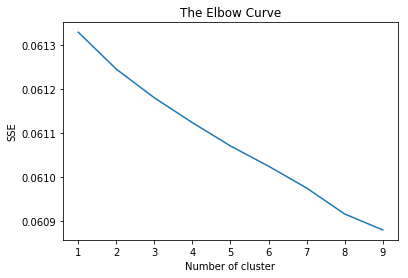

In [81]:
#Apply K-means clustering on the model
from sklearn.cluster import KMeans 
#Applying Elbow method to find the optimum number of clusters
import matplotlib.pyplot as plt
%matplotlib inline
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=5).fit(doc2vec_model.docvecs.doctag_syn0)
    #data["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title("The Elbow Curve")
plt.show()

# 5 seems to be optimum cluster size

In [23]:
doc2vec_model.docvecs.doctag_syn0

C:\Users\agadiya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """Entry point for launching an IPython kernel.


array([[-0.00330239, -0.00088519, -0.00413987, ...,  0.00363264,
        -0.00406904,  0.00433124],
       [-0.0042667 , -0.00126348, -0.00568444, ...,  0.00488919,
        -0.00595728,  0.00604821],
       [-0.00128824, -0.00029536, -0.00171895, ...,  0.00169138,
        -0.00173186,  0.00183459],
       ...,
       [-0.00263566, -0.00077459, -0.00341302, ...,  0.00271899,
        -0.0032969 ,  0.00309356],
       [-0.00495057, -0.00129719, -0.00654586, ...,  0.00547581,
        -0.00656428,  0.00648171],
       [-0.00140327, -0.00042303, -0.00167121, ...,  0.00143187,
        -0.00146407,  0.00188356]], dtype=float32)

In [24]:
len(doc2vec_model.docvecs.doctag_syn0)

C:\Users\agadiya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """Entry point for launching an IPython kernel.


1473

In [25]:
#Fit the k-means model
import random
kmeans_model = KMeans(n_clusters=5, init='k-means++', max_iter=100,random_state=0) 
X = kmeans_model.fit(doc2vec_model.docvecs.doctag_syn0)


C:\Users\agadiya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  after removing the cwd from sys.path.


In [26]:
#Assign cluster numbers to the different documents based on the k-means 
l = X.fit_predict(doc2vec_model.docvecs.doctag_syn0)

C:\Users\agadiya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  


In [27]:
l

array([3, 1, 0, ..., 3, 2, 0])

In [28]:
labels_df=pd.DataFrame(l)
result = pd.concat([df_google_low_rating, labels_df], axis=1, join_axes=[df_google_low_rating.index])

In [29]:
result.head()

,title_revs_lemmatized,0
1,recently not able get spectrum screen kept pro...,1
4,crash constantly,1
11,foesnt want done nut,1
13,super slow,1
15,terrible keep crashing wasn able pay bill,1


In [30]:
result.columns = ['google_cleaned_lemm_reviews','cluster_id']

In [31]:
result.head()

,google_cleaned_lemm_reviews,cluster_id
1,recently not able get spectrum screen kept pro...,1
4,crash constantly,1
11,foesnt want done nut,1
13,super slow,1
15,terrible keep crashing wasn able pay bill,1


In [32]:
google_review_cluster1 = result[result['cluster_id']==1]
google_review_cluster2 = result[result['cluster_id']==2]
google_review_cluster3 = result[result['cluster_id']==3]
google_review_cluster4 = result[result['cluster_id']==4]
google_review_cluster5 = result[result['cluster_id']==5]

In [66]:
print(len(google_review_cluster1))
print(len(google_review_cluster2))
print(len(google_review_cluster3))
print(len(google_review_cluster4))
print(len(google_review_cluster5))

569
181
544
11
0


we will apply LDA topic modelling on cluster1, cluster2, cluster3 and cluster 4 reviews now.

In [34]:
# Use this function to extract top words from the topics, make sure you document the hyperparameters used for
# tfidf and LDA models
def extract_top_words(lda_model, corpus, num_words=10):
    topics_list = lda_model.top_topics(corpus=corpus, topn=num_words)
    all_topics = []
    for idx, topic in enumerate(topics_list):
        topic_words = []
        for j in topic[0]:
            topic_words.append(j[1])
        all_topics.append(('topic #{}'.format(idx), ', '.join(topic_words)))
    return all_topics

In [59]:
                                         #### Google Corpus cluster 1 Topic Modeling ####

"""Assign values to hyper parameters here"""
max_df=.75
min_df=.01
passes=20
iterations=500
num_topics=8

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3),
                                   max_df=max_df,
                                   min_df=min_df) 

tfidf_google_low_rating_cluster1 = tfidf_vectorizer.fit_transform(google_review_cluster1.google_cleaned_lemm_reviews.values)
tfidf_google_low_rating_cluster1_csc = tfidf_google_low_rating_cluster1.tocsc().T

# Create dictionary of words and indices for topic extraction later
google_low_rating_vocab = {v: k for k, v in tfidf_vectorizer.vocabulary_.items()}

#  Convert sparse matrix into Gensim BOW format for faster training
corpus_google_low_rating_cluster1 = Sparse2Corpus(tfidf_google_low_rating_cluster1_csc, documents_columns=True)


# Train LDA Model, use random state for reproducibility
# Make sure you adjust name of model variable according to number of topics you select for consistency
lda_11_google_topics_cluster1 = LdaMulticore(corpus_google_low_rating_cluster1, 
                             id2word=google_low_rating_vocab, 
                             workers=3,
                             num_topics=num_topics, 
                             random_state=10,
                             passes=passes,
                             iterations=iterations)

"""Set function parameters"""
num_words = 11
lda_model = lda_11_google_topics_cluster1
corpus = corpus_google_low_rating_cluster1

extracted_words = extract_top_words(lda_model=lda_model, corpus=corpus_google_low_rating_cluster1, num_words=num_words)

for topic in extracted_words:
    print(topic)

('topic #0', 'need, keep, not, take, pay, load, don, bill, still, pay bill, get')
('topic #1', 'company, service, like, spectrum, garbage, good, better, way, no, bill, cable')
('topic #2', 'work, not, won, not work, phone, log, account, screen, time, info, let')
('topic #3', 'spectrum, doesn, doesn work, pay, bill, work, pay bill, never, page, useless, hate')
('topic #4', 'slow, want, wifi, could, wish, password, option, warner, time warner, time, change')
('topic #5', 'suck, open, time, log, every time, every, try, won, no, crash, spectrum suck')
('topic #6', 'twc, payment, nothing, used, mytwc, would, feature, going, unable, able, useless')
('topic #7', 'crash, please, fix, house, ever, bright house, bright, use, much, worst, terrible')


In [60]:
                                   #### Google Corpus cluster 2 Topic Modeling ####

"""Assign values to hyper parameters here"""
max_df=.75
min_df=.01
passes=20
iterations=500
num_topics=8

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3),
                                   max_df=max_df,
                                   min_df=min_df) 

tfidf_google_low_rating_cluster2 = tfidf_vectorizer.fit_transform(google_review_cluster2.google_cleaned_lemm_reviews.values)
tfidf_google_low_rating_cluster2_csc = tfidf_google_low_rating_cluster2.tocsc().T

# Create dictionary of words and indices for topic extraction later
google_low_rating_vocab = {v: k for k, v in tfidf_vectorizer.vocabulary_.items()}

#  Convert sparse matrix into Gensim BOW format for faster training
corpus_google_low_rating_cluster2 = Sparse2Corpus(tfidf_google_low_rating_cluster2_csc, documents_columns=True)


# Train LDA Model, use random state for reproducibility
# Make sure you adjust name of model variable according to number of topics you select for consistency
lda_11_google_topics_cluster2 = LdaMulticore(corpus_google_low_rating_cluster2, 
                             id2word=google_low_rating_vocab, 
                             workers=3,
                             num_topics=num_topics, 
                             random_state=10,
                             passes=passes,
                             iterations=iterations)

"""Set function parameters"""
num_words = 11
lda_model = lda_11_google_topics_cluster2
corpus = corpus_google_low_rating_cluster2

extracted_words = extract_top_words(lda_model=lda_model, corpus=corpus_google_low_rating_cluster2, num_words=num_words)

for topic in extracted_words:
    print(topic)

('topic #0', 'slow, pay, like, service, pay bill, bill, spectrum, information, crash, much, not')
('topic #1', 'spectrum, work, doesn, keep, hate, doesn work, charter, never work, never, pay, auto pay')
('topic #2', 'take, paying, would, really, trouble, load, paying bill, bill, use, time, twc')
('topic #3', 'freeze, twc way, twc way better, way better, better, never, not, try, way, log, doesn')
('topic #4', 'no, time, password, company, screen, update, work, see, also, worse, due')
('topic #5', 'worst, contact, bad, not, always, no, go, crash, internet, even, term')
('topic #6', 'always, payment, cannot, glitch, card, save, awful, user, spectrum, time, fast')
('topic #7', 'don, download, let, continues, success, won, billing, never, able, forced, wasn')


In [64]:
                                         #### Google Corpus cluster 3 Topic Modeling ####

"""Assign values to hyper parameters here"""
max_df=.75
min_df=.01
passes=20
iterations=500
num_topics=8

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3),
                                   max_df=max_df,
                                   min_df=min_df) 

tfidf_google_low_rating_cluster3 = tfidf_vectorizer.fit_transform(google_review_cluster3.google_cleaned_lemm_reviews.values)
tfidf_google_low_rating_cluster3_csc = tfidf_google_low_rating_cluster3.tocsc().T

# Create dictionary of words and indices for topic extraction later
google_low_rating_vocab = {v: k for k, v in tfidf_vectorizer.vocabulary_.items()}

#  Convert sparse matrix into Gensim BOW format for faster training
corpus_google_low_rating_cluster3 = Sparse2Corpus(tfidf_google_low_rating_cluster3_csc, documents_columns=True)


# Train LDA Model, use random state for reproducibility
# Make sure you adjust name of model variable according to number of topics you select for consistency
lda_11_google_topics_cluster3 = LdaMulticore(corpus_google_low_rating_cluster3, 
                             id2word=google_low_rating_vocab, 
                             workers=3,
                             num_topics=num_topics, 
                             random_state=10,
                             passes=passes,
                             iterations=iterations)

"""Set function parameters"""
num_words = 11
lda_model = lda_11_google_topics_cluster3
corpus = corpus_google_low_rating_cluster3

extracted_words = extract_top_words(lda_model=lda_model, corpus=corpus_google_low_rating_cluster3, num_words=num_words)

for topic in extracted_words:
    print(topic)

('topic #0', 'no, service, need, spectrum, bill, not, pay, don, customer, go, charter')
('topic #1', 'work, suck, doesn, time, won, doesn work, open, even, always, info, forced')
('topic #2', 'company, payment, much, constantly, show, make, bill, make payment, better, issue, use')
('topic #3', 'pay, bill, slow, pay bill, open, not, update, start, useless, payment, statement')
('topic #4', 'spectrum, not, wifi, get, garbage, good, card, information, email, worst, ve')
('topic #5', 'use, service, log, load, forever, could, take forever, take, bad, say, wish')
('topic #6', 'not, not work, terrible, work, mytwc, twc, warner, functionality, helpful, much, time warner')
('topic #7', 'password, hate, crash, change, keep, many, login, everything, lot, people, way')


In [ ]:
                                    #### Google Corpus cluster 4 Topic Modeling ####

"""Assign values to hyper parameters here"""
max_df=.55
min_df=.01
passes=20
iterations=500
num_topics=8

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3),
                                   max_df=max_df,
                                   min_df=min_df) 

tfidf_google_low_rating_cluster4 = tfidf_vectorizer.fit_transform(google_review_cluster4.google_cleaned_lemm_reviews.values)
tfidf_google_low_rating_cluster4_csc = tfidf_google_low_rating_cluster3.tocsc().T

# Create dictionary of words and indices for topic extraction later
google_low_rating_vocab = {v: k for k, v in tfidf_vectorizer.vocabulary_.items()}

#  Convert sparse matrix into Gensim BOW format for faster training
corpus_google_low_rating_cluster4 = Sparse2Corpus(tfidf_google_low_rating_cluster4_csc, documents_columns=True)


# Train LDA Model, use random state for reproducibility
# Make sure you adjust name of model variable according to number of topics you select for consistency
lda_11_google_topics_cluster4 = LdaMulticore(corpus_google_low_rating_cluster4, 
                             id2word=google_low_rating_vocab, 
                             workers=3,
                             num_topics=num_topics, 
                             random_state=10,
                             passes=passes,
                             iterations=iterations)

"""Set function parameters"""
num_words = 11
lda_model = lda_11_google_topics_cluster4
corpus = corpus_google_low_rating_cluster4

extracted_words = extract_top_words(lda_model=lda_model, corpus=corpus_google_low_rating_cluster4, num_words=num_words)

for topic in extracted_words:
    print(topic)

In [49]:
                                            #### Google Corpus Topic Modeling ####

# TODO: Experiment with max_df and min_df parameters in TfidfVectorizer - Read the link for explanation of these parameters
# https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

"""Assign values to hyper parameters here"""
max_df=.55
min_df=.02
passes=10
iterations=400
num_topics=20

# Apply term frequency-Inverse document frequency with 1 to 3 N-grams to Google low rating corpus, you could try 1-2 ngrams
# Convert tfidf matrix into csc format so gensim model can read the matrix
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3),
                                   max_df=max_df,
                                   min_df=min_df) 
tfidf_google_low_rating = tfidf_vectorizer.fit_transform(df_google_low_rating.values)
tfidf_google_low_rating_csc = tfidf_google_low_rating.tocsc().T


# Create dictionary of words and indices for topic extraction later
google_low_rating_vocab = {v: k for k, v in tfidf_vectorizer.vocabulary_.items()}

#  Convert sparse matrix into Gensim BOW format for faster training
corpus_google_low_rating = Sparse2Corpus(tfidf_google_low_rating_csc, documents_columns=True)


# Train LDA Model, use random state for reproducibility
# Make sure you adjust name of model variable according to number of topics you select for consistency
lda_11_google_topics = LdaMulticore(corpus_google_low_rating, 
                             id2word=google_low_rating_vocab, 
                             workers=3,
                             num_topics=num_topics, 
                             random_state=10,
                             passes=passes,
                             iterations=iterations)

In [52]:
"""Set function parameters"""
num_words = 10
lda_model = lda_11_google_topics
corpus = corpus_google_low_rating

extracted_words = extract_top_words(lda_model=lda_model, corpus=corpus_google_low_rating, num_words=num_words)

for topic in extracted_words:
    print(topic)

('topic #0', 'always, never, info, billing, work, account, not, time, get, payment')
('topic #1', 'payment, due, card, say, bill, still, pay, show, not, no')
('topic #2', 'go, screen, good, customer, going, spectrum, not, service, paying, month')
('topic #3', 'service, don, ever, worst, spectrum, internet, month, get, ve, customer')
('topic #4', 'need, access, useless, update, phone, problem, new, not, work, many')
('topic #5', 'terrible, garbage, thing, error, spectrum, pay, company, service, bill, like')
('topic #6', 'log, see, show, able, account, doesn, nothing, let, even, not')
('topic #7', 'way, option, money, give, trying, support, useless, need, day, no')
('topic #8', 'load, take, not, like, would, need, spectrum, want, time, internet')
('topic #9', 'payment, wish, warner, could, time warner, make, time, make payment, information, would')
('topic #10', 'twc, use, spectrum, old, anything, easy, one, better, like, not')
('topic #11', 'suck, open, won, even, login, internet, spect

In [51]:
# Train models for a range of topic numbers for low ratings from Google Play Store and trained model in a dictionary
# Workers is the number of cores your computer has -1 (I assume you have an i7 Quad Core CPU)
# Random state set for reproducibility
# Can adjust passes and iterations function arguments and analyze results/performance

lda_models = {'lda_google_{}_topics'.format(num_tops): LdaMulticore(corpus_google_low_rating, 
                                                                     id2word=google_low_rating_vocab,
                                                                     workers=3,
                                                                     num_topics=num_tops, 
                                                                     random_state=10,
                                                                     passes=40,
                                                                     iterations=400) for num_tops in range(7, 14)}

In [52]:
print(lda_models)

{'lda_google_7_topics': <gensim.models.ldamulticore.LdaMulticore object at 0x000001FB532C7E48>, 'lda_google_8_topics': <gensim.models.ldamulticore.LdaMulticore object at 0x000001FB532C7FD0>, 'lda_google_9_topics': <gensim.models.ldamulticore.LdaMulticore object at 0x000001FB532C7E80>, 'lda_google_10_topics': <gensim.models.ldamulticore.LdaMulticore object at 0x000001FB532C7F60>, 'lda_google_11_topics': <gensim.models.ldamulticore.LdaMulticore object at 0x000001FB1FAEC828>, 'lda_google_12_topics': <gensim.models.ldamulticore.LdaMulticore object at 0x000001FB29628978>, 'lda_google_13_topics': <gensim.models.ldamulticore.LdaMulticore object at 0x000001FB25D3AEF0>}


In [53]:
#Train models for a range of topic numbers for low ratings from Apple App Store
lda_models = {'lda_apple_{}_topics'.format(num_tops): LdaMulticore(corpus_apple_low_rating, 
                                                                     id2word=apple_low_rating_vocab,
                                                                     workers=3,
                                                                     num_topics=num_tops, 
                                                                     random_state=10,
                                                                     passes=40,
                                                                     iterations=400) for num_tops in range(7, 14)}

In [94]:
from gensim.models import doc2vec
from collections import namedtuple
# Load data

doc1 = ["This is a sentence", "This is another sentence","This is beautiful"]

docs=[]
analyzedDocument = namedtuple('AnalyzedDocument','word tags')

for i,text in enumerate(doc1):
    print(text)
    words = text.lower().split()
    print(words)
    tags = [i]
    docs.append(analyzedDocument(words,tags))
    print(analyzedDocument(words,tags))
    print(docs)

This is a sentence
['this', 'is', 'a', 'sentence']
AnalyzedDocument(word=['this', 'is', 'a', 'sentence'], tags=[0])
[AnalyzedDocument(word=['this', 'is', 'a', 'sentence'], tags=[0])]
This is another sentence
['this', 'is', 'another', 'sentence']
AnalyzedDocument(word=['this', 'is', 'another', 'sentence'], tags=[1])
[AnalyzedDocument(word=['this', 'is', 'a', 'sentence'], tags=[0]), AnalyzedDocument(word=['this', 'is', 'another', 'sentence'], tags=[1])]
This is beautiful
['this', 'is', 'beautiful']
AnalyzedDocument(word=['this', 'is', 'beautiful'], tags=[2])
[AnalyzedDocument(word=['this', 'is', 'a', 'sentence'], tags=[0]), AnalyzedDocument(word=['this', 'is', 'another', 'sentence'], tags=[1]), AnalyzedDocument(word=['this', 'is', 'beautiful'], tags=[2])]


In [99]:
# Import libraries

# Transform data (you can add more data preprocessing steps) 

docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, text in enumerate(doc1):
    words = text.lower().split()
    tags = [i]
    docs.append(analyzedDocument(words, tags))

# Train model (set min_count = 1, if you want the model to work with the provided example data set)

model = doc2vec.Doc2Vec(docs, size = 100, window = 10, min_count = 3, workers = 4)

# Get the vectors

model.docvecs[2]

C:\Users\agadiya\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


array([-4.3454403e-03, -2.0636960e-03, -1.7819713e-03,  5.6815409e-04,
        3.4293605e-04, -9.5218141e-04, -3.9002567e-03, -6.6662434e-04,
       -1.3257841e-03, -4.5936690e-03,  1.3958857e-03, -1.7538045e-03,
       -4.4178159e-04,  2.5958198e-03, -2.0112996e-03,  1.7190001e-03,
       -3.8740707e-03,  2.5717567e-03,  9.8780228e-04,  4.8594056e-03,
        1.4785058e-03,  3.1791264e-03, -4.5282487e-03,  1.2653398e-03,
        1.5089886e-03, -2.6644545e-03,  3.3957439e-03,  3.0621057e-03,
        2.8888246e-03, -3.9920872e-03, -4.3037399e-03, -4.9300934e-03,
        4.1536815e-04, -4.2818394e-03, -4.8478073e-03,  1.2925331e-03,
       -7.4598787e-04,  3.1384374e-03, -3.7253432e-03, -1.8178194e-03,
        1.6444839e-03,  4.7868150e-03,  4.5120642e-03,  2.8847060e-03,
        3.2310311e-03,  1.2449314e-03, -1.2654008e-03, -1.8375608e-04,
        3.6202583e-03, -3.7807205e-03, -2.2755344e-03,  4.5548114e-03,
       -4.0407879e-03, -1.2787429e-03,  3.3519098e-03,  3.2260455e-03,
      